# E-Commerce Brazil

# 1 Understanding the Data

In [1]:
%pip install --upgrade plotly
%pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 123.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

import json
import re

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from PIL import Image

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

There are 6 files with have information about the customers, orders, payment methods and sellers.   

In [4]:
df_customers = pd.read_csv("/olist_customers_dataset.csv")
df_itens = pd.read_csv("/olist_order_items_dataset.csv")
df_payments = pd.read_csv("/olist_order_payments_dataset.csv")
df_reviews = pd.read_csv("/olist_order_reviews_dataset.csv")
df_order_status = pd.read_csv("/olist_orders_dataset.csv")
df_sellers = pd.read_csv("/olist_sellers_dataset.csv")
df_products = pd.read_csv("/olist_products_dataset.csv")


## 1.1 Customers Data

Customer Data Features:
1. customer_id
2. customer_unique_id
3. customer_zip_code_prefix
4. customer_city
5. customer_state


Lets take a look at the customer data:


In [5]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
df_customers.shape

(99441, 5)

In [7]:
print(f"Nan values: {df_customers.isna().values.any()}")
print(f"Duplicated: {df_customers.duplicated().values.any()}")

Nan values: False
Duplicated: False


Lets explore the features.

In [8]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [9]:
print(df_customers["customer_id"].nunique())
print(df_customers["customer_unique_id"].nunique())

99441
96096


The "customer_id" treat every purchase as a different value. The "customer_unique_id" referers  of a individual client to identidy. As a unique client can make more than 1 purchase there are more values in the "customer_id" column.

For the states:

In [10]:
num_states = df_customers["customer_state"].value_counts()
num_states

SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_state, dtype: int64

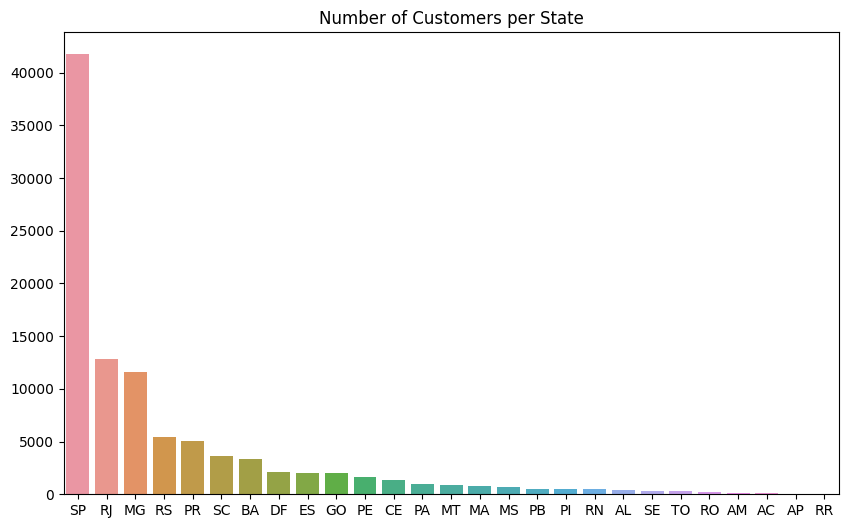

In [11]:
plt.figure(figsize=(10,6))
sns.barplot(x=num_states.index, y=num_states.values)
plt.title("Number of Customers per State")
plt.show()

Most of the purchases have happen in SP, RJ and MG. That are the 3 more populous states. Lets see the cities:

In [12]:
num_city = df_customers["customer_city"].value_counts()
num_city[:10]

sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
Name: customer_city, dtype: int64

The capitals of the 3 most prevalent states happen to be the cities with the most instances in the data. Lets take a look of the data geographcally.

## 1.2 Seller Data 

In [13]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [14]:
print(f"Nan values: {df_sellers.isna().values.any()}")
print(f"Duplicated: {df_sellers.duplicated().values.any()}")

Nan values: False
Duplicated: False


In [15]:
df_sellers.shape

(3095, 4)

In [16]:
state_sellers = df_sellers["seller_state"].value_counts()
state_sellers

SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
CE      13
PE       9
PB       6
RN       5
MS       5
MT       4
RO       2
SE       2
PI       1
AC       1
MA       1
AM       1
PA       1
Name: seller_state, dtype: int64

## 1.3. Itens Data

Feauteres in the dataset:
1. order_id
2. order_item_id (number of items in the same order)
3. product_id
4. seller_id
5. shipping_date_limit  
6. price
7. freight_value

In [17]:
df_itens.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [18]:
df_itens.shape

(112650, 7)

In [19]:
print(f"Nan values: {df_itens.isna().values.any()}")
print(f"Duplicated: {df_itens.duplicated().values.any()}")

Nan values: False
Duplicated: False


### 1.3.1 Distribution of Values

<Figure size 800x1000 with 0 Axes>

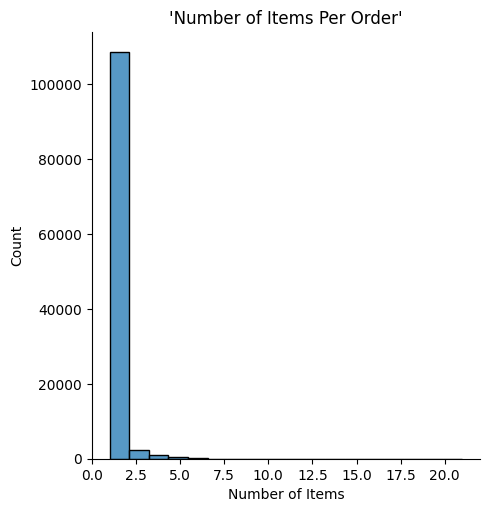

In [20]:
plt.figure(figsize=(8,10))
sns.displot(df_itens, x='order_item_id')
plt.title("'Number of Items Per Order'")
plt.xlabel("Number of Items")
plt.show()

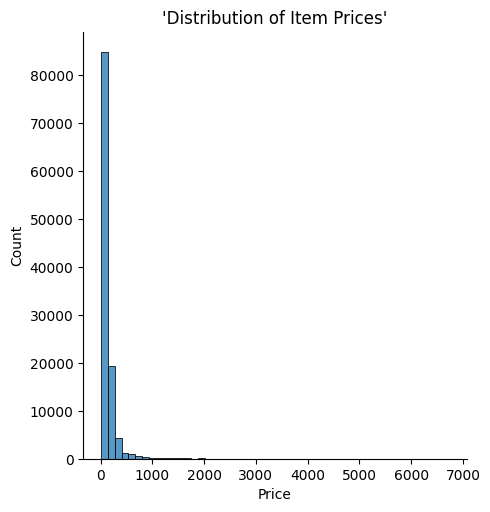

In [21]:
sns.displot(df_itens, x='price', bins=50)
plt.title("'Distribution of Item Prices'")
plt.xlabel("Price")
plt.show()

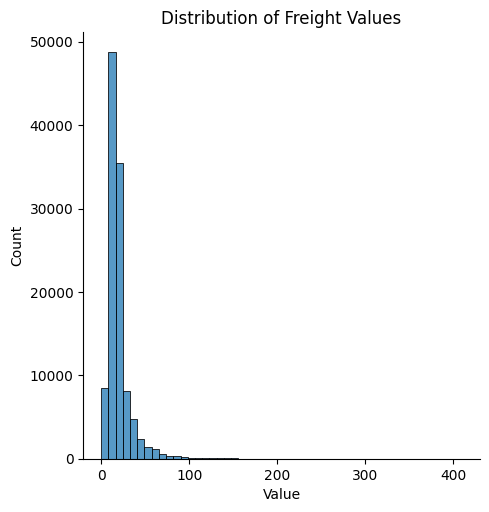

In [22]:
sns.displot(df_itens, x='freight_value', bins=50)
plt.title('Distribution of Freight Values')
plt.xlabel("Value")
plt.show()

## 1.4 Payments Data

Feauteres in the dataset:
1. order_id
2. payment_sequential
3. payment_type
4. payment_installments
5. payment_value  


In [23]:
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [24]:
print(f"Nan values: {df_payments.isna().values.any()}")
print(f"Duplicated: {df_payments.duplicated().values.any()}")

Nan values: False
Duplicated: False


In [25]:
pay_type = df_payments["payment_type"].value_counts()
pay_type

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

Text(0, 0.5, 'Frequency')

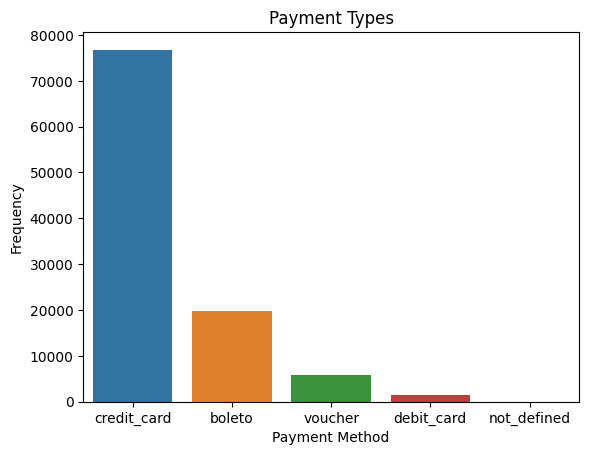

In [26]:
sns.barplot(x=pay_type.index, y=pay_type.values)
plt.title("Payment Types")
plt.xlabel("Payment Method")
plt.ylabel("Frequency")

## 1.5 Reviews Data

Feauteres in the dataset:
1. review_id
2. order_id
3. review_score
4. review_comment_title
5. review_comment_message  
6. review_creation_date
7. review_answer_timestamp

In [27]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [28]:
df_reviews.shape

(99224, 7)

In [29]:
print(f"Nan values: {df_reviews.isna().values.any()}")
print(f"Duplicated: {df_reviews.duplicated().values.any()}")

Nan values: True
Duplicated: False


In [30]:
df_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

A lot of peolpe leave a review without body or title text.

In [31]:
score_count = df_reviews['review_score'].value_counts()

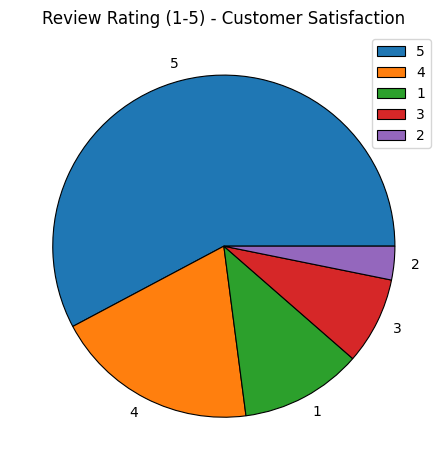

In [32]:
plt.pie(score_count, labels = score_count.index, wedgeprops = {"edgecolor" : "black",'linewidth': 0.8})
plt.title('Review Rating (1-5) - Customer Satisfaction')
plt.tight_layout()
plt.legend()

## 1.6 Orders Data

Orders data features:
1. order_id
2. customer_id
3. order_status
4. order_purchase_timestamp
5. order_approved_at
6. order_delivered_carreir_date
7. order_delivered_customer_date
8. order_estimated_delivery_date

In [33]:
df_order_status.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [34]:
df_order_status.shape

(99441, 8)

In [35]:
print(f"Nan values: {df_order_status.isna().values.any()}")
print(f"Duplicated: {df_order_status.duplicated().values.any()}")

Nan values: True
Duplicated: False


In [36]:
df_order_status.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [37]:
df_order_status[df_order_status['order_delivered_customer_date'].isnull()].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


The missing values are related to a failure  shipping steps.

In [38]:
df_order_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [39]:
order_status=df_order_status['order_status'].value_counts()/df_order_status['order_status'].count()
order_status

delivered     0.97
shipped       0.01
canceled      0.01
unavailable   0.01
invoiced      0.00
processing    0.00
created       0.00
approved      0.00
Name: order_status, dtype: float64

97 % of orders were successfully delivered.

## 1.7 Products Data

In [40]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.00,287.00,1.00,225.00,16.00,10.00,14.00
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.00,276.00,1.00,"1,000.00",30.00,18.00,20.00
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.00,250.00,1.00,154.00,18.00,9.00,15.00
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.00,261.00,1.00,371.00,26.00,4.00,26.00
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.00,402.00,4.00,625.00,20.00,17.00,13.00


In [41]:
print(f"Nan values: {df_products.isna().values.any()}")
print(f"Duplicated: {df_products.duplicated().values.any()}")

Nan values: True
Duplicated: False


In [42]:
df_products.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [43]:
categories = df_products['product_category_name'].value_counts()
top30 = categories[:30]

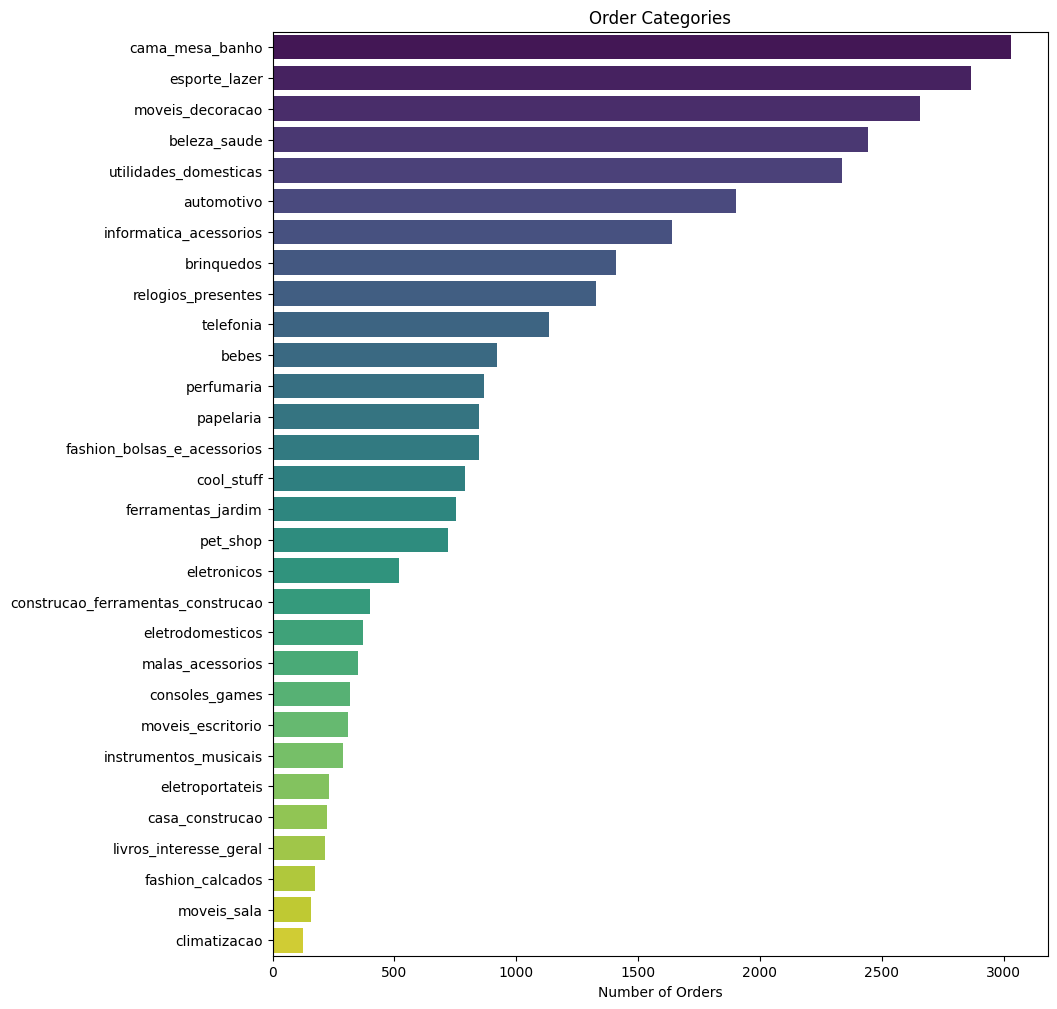

In [44]:
plt.figure(figsize=(10,12))
sns.barplot(x=top30.values, y=top30.index, palette='viridis')
plt.title("Order Categories")
plt.xlabel('Number of Orders')
plt.show()


# 2 Sales and Time Series Forecasting - Corrigir tudo a partr daqui


In this section we will look at the product categories and how they relate with sales and reviews from clients. 

## 2.1 Customer and Seller Distribuition 

In [45]:
num_states = df_customers["customer_state"].value_counts()

In [46]:
# geojson = json.load(open('/content/drive/MyDrive/E-commerce Project/brazil_geo (1).json'))
# map_states = px.choropleth(locations=num_states.index, color=num_states.values, title="Purchase per State", geojson=geojson, scope='south america', color_continuous_scale=px.colors.sequential.matter)
# map_states.update_layout(coloraxis_showscale=True)
# map_states.show()

In [47]:
state_sellers = df_sellers["seller_state"].value_counts()

In [48]:
# geojson = json.load(open(/content/drive/MyDrive/E-commerce Project/brazil_geo (1).json'))
# map_states_sell = px.choropleth(locations=state_sellers.index, color=state_sellers.values, title="Sellers per State", geojson=geojson, scope='south america', color_continuous_scale=px.colors.sequential.matter)
# map_states_sell.update_layout(coloraxis_showscale=True)
# map_states_sell.show()

## 2.1 Category Revenue and Reviews

In [49]:
df = pd.merge(df_itens, df_products, on='product_id', how="inner")
merge = df[['order_id', 'order_item_id', 'product_id','seller_id', 'price', 'freight_value', 'product_category_name']]
merge.head()

,order_id,order_item_id,product_id,seller_id,price,freight_value,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.90,17.96,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.90,18.33,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,16.17,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff


In [50]:
# to_drop = merge.loc[merge['order_id'].duplicated()]
# merge.drop(to_drop.index, inplace=True)
merge.shape

(112650, 7)

In [51]:
df_review_cat = merge.merge(df_reviews, on='order_id', how='inner')
df_review_cat.drop(['review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp'], axis=1, inplace=True)
df_review_cat.head(10)

,order_id,order_item_id,product_id,seller_id,price,freight_value,product_category_name,review_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff,97ca439bc427b48bc1cd7177abe71365,5
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.90,17.96,cool_stuff,b11cba360bbe71410c291b764753d37f,5
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.90,18.33,cool_stuff,af01c4017c5ab46df6cc810e069e654a,4
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,16.17,cool_stuff,8304ff37d8b16b57086fa283fe0c44f8,5
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff,426f43a82185969503fb3c86241a9535,5
5,a0f9acf0b6294ed8561e32cde1a966bc,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.90,26.93,cool_stuff,c752337ac465a5e2fbdbedf7d79c6659,5
6,bbf796534aaf9c59f8da8c7982db56e0,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.90,38.50,cool_stuff,b41646a4365a1411101396c097413907,5
7,c9ef97d2854afe64a3b4488bc2836af6,2,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,18.12,cool_stuff,dbacd3ac90ace7ad49fe8b31bbad2808,5
8,c9ef97d2854afe64a3b4488bc2836af6,1,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,58.90,17.83,cool_stuff,dbacd3ac90ace7ad49fe8b31bbad2808,5
9,df2d910b8b5e5f461f67043489f9569d,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.90,35.71,cool_stuff,4e58c72bb0373240b2bd9bf84b493a69,1


In [52]:
df_review_cat.shape

(112372, 9)

In [53]:
df_gb_cat = df_review_cat.groupby(['product_category_name']).agg({"price":"mean", "review_score": "mean"}).reset_index()
df_gb_cat.head()

,product_category_name,price,review_score
0,agro_industria_e_comercio,342.12,4.00
1,alimentos,58.46,4.22
2,alimentos_bebidas,54.64,4.32
3,artes,116.12,3.94
4,artes_e_artesanato,75.58,4.12


In [54]:
df_gb_cat_bottom = df_gb_cat.sort_values(['review_score'])

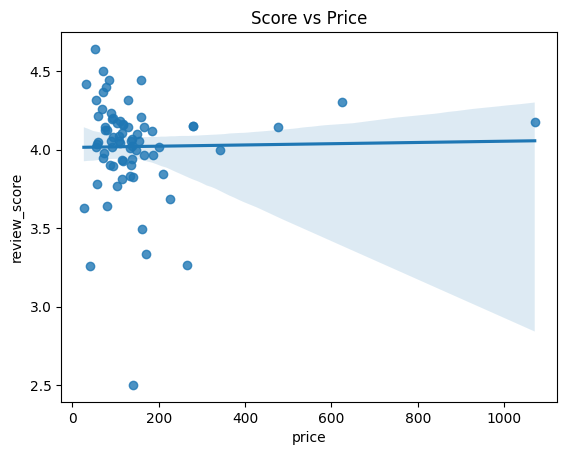

In [55]:
sns.regplot(data=df_gb_cat, x='price', y='review_score')
plt.title('Score vs Price')
plt.show()

There are no aparent relationships between price and ratings.

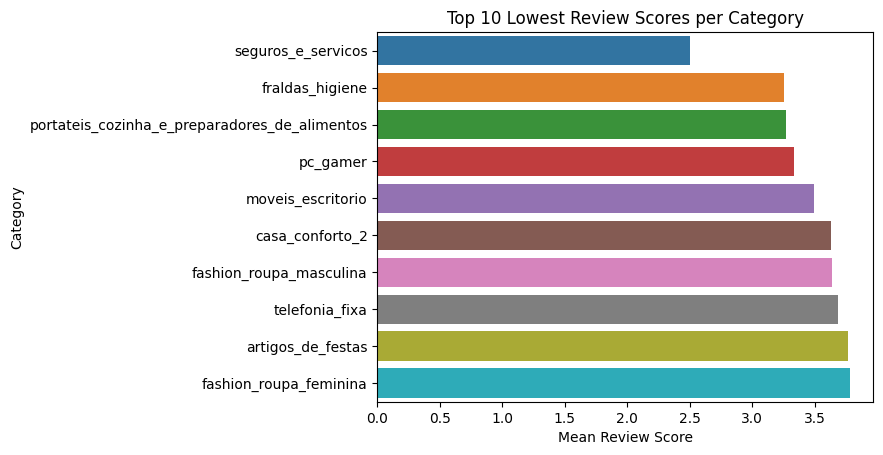

In [56]:
bottom10 = df_gb_cat_bottom[:10]
sns.barplot(data=bottom10, x='review_score', y='product_category_name')
plt.title('Top 10 Lowest Review Scores per Category')
plt.xlabel('Mean Review Score')
plt.ylabel('Category')
plt.show()

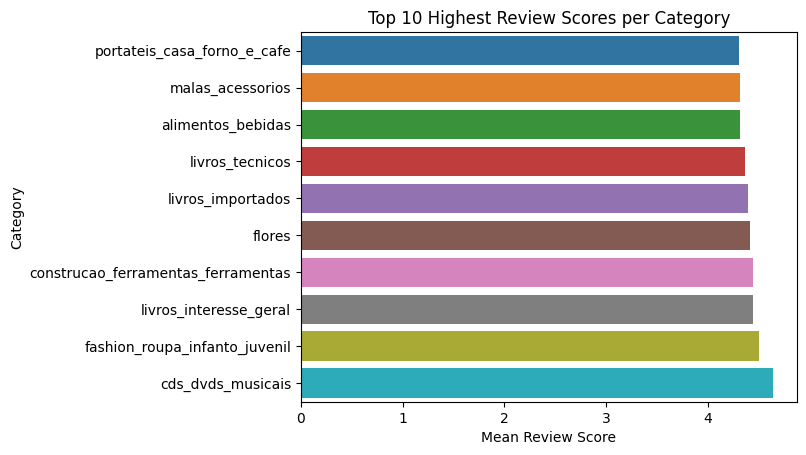

In [57]:
top10 = df_gb_cat_bottom[-10:]
sns.barplot(data=top10, x='review_score', y='product_category_name')
plt.title('Top 10 Highest Review Scores per Category')
plt.xlabel('Mean Review Score')
plt.ylabel('Category')
plt.show()

The three lowest review scores are from "seguros-e-servicos","fraldas_higiene", "portateis_cozinha_e_preparadores_de_alimento".And the highest are "cds_dvds_musicais", "fashion_roupas_infanto_juvenil"

## 2.2 Total amount of revenue per Category

In [58]:
df_rev_cat = df_review_cat.groupby(['product_category_name']).agg({"price":"sum"}).reset_index()
df_rev_cat.sort_values(by=['price'], ascending=False, inplace=True)
df_rev_cat.head()

,product_category_name,price
11,beleza_saude,"1,252,404.85"
66,relogios_presentes,"1,197,565.48"
13,cama_mesa_banho,"1,040,140.31"
32,esporte_lazer,"986,848.92"
44,informatica_acessorios,"914,579.39"


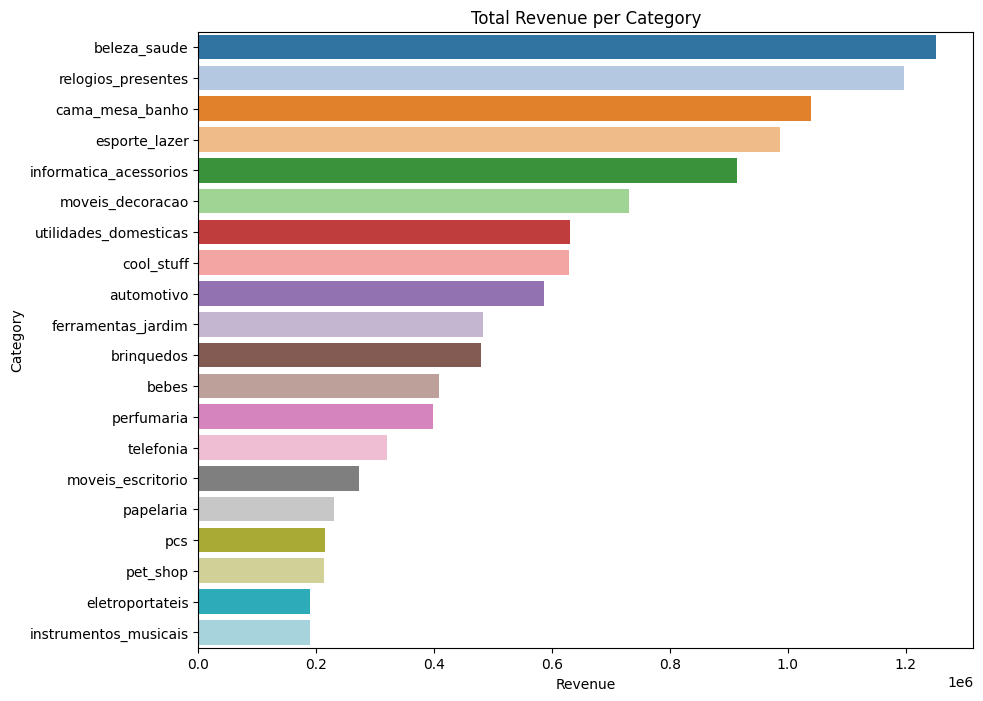

In [59]:
top20 = df_rev_cat[:20]
plt.figure(figsize=(10,8))
sns.barplot(data=top20, x='price', y='product_category_name', palette='tab20')
plt.title('Total Revenue per Category')
plt.xlabel('Revenue')
plt.ylabel('Category')

plt.show()

##  2.3 Time Series

In [60]:
time_series = df_order_status.merge(df_itens, on='order_id', how='inner')
time_series.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112649,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00,1,006619bbed68b000c8ba3f8725d5409e,ececbfcff9804a2d6b40f589df8eef2b,2018-03-15 10:55:42,68.50,18.36


In [61]:
time_series.shape

(112650, 14)

In [62]:
time_series_clean = time_series[['order_id', 'order_purchase_timestamp', 'price']]
time_series_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  112650 non-null  object 
 1   order_purchase_timestamp  112650 non-null  object 
 2   price                     112650 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.4+ MB


In [63]:
time_series_clean['order_purchase_timestamp']=pd.to_datetime(time_series_clean['order_purchase_timestamp'])
time_series_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  112650 non-null  object        
 1   order_purchase_timestamp  112650 non-null  datetime64[ns]
 2   price                     112650 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.4+ MB


<ipython-input-63-1a7a07afd142>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_clean['order_purchase_timestamp']=pd.to_datetime(time_series_clean['order_purchase_timestamp'])


In [64]:
time_series_clean['convert_time']=pd.to_datetime(time_series_clean['order_purchase_timestamp'].dt.strftime('%Y-%m-%d'))
time_series_clean.head()

<ipython-input-64-78ff90729088>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_clean['convert_time']=pd.to_datetime(time_series_clean['order_purchase_timestamp'].dt.strftime('%Y-%m-%d'))


,order_id,order_purchase_timestamp,price,convert_time
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,19.90,2018-02-13


In [65]:
sales_day=time_series_clean.groupby(["convert_time"]).agg({"order_id":"count", 'price':"sum"}).reset_index()
sales_day

,convert_time,order_id,price
0,2016-09-04,2,72.89
1,2016-09-05,1,59.50
2,2016-09-15,3,134.97
3,2016-10-02,1,100.00
4,2016-10-03,8,463.48
...,...,...,...
611,2018-08-26,82,"8,070.71"
612,2018-08-27,71,"5,345.91"
613,2018-08-28,45,"3,673.91"
614,2018-08-29,16,"1,546.04"


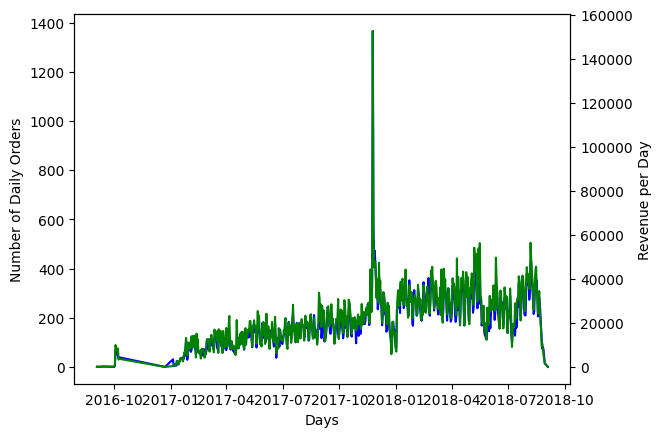

In [66]:
fig,ax = plt.subplots()
ax.plot(sales_day.convert_time, sales_day.order_id, color="blue")
ax.set_xlabel("Days")
ax.set_ylabel("Number of Daily Orders")


ax2 = ax.twinx()

ax2.plot(sales_day.convert_time, sales_day.price, color="green")
ax2.set_ylabel("Revenue per Day")
plt.show()

In [67]:
sales_day[sales_day['order_id']==sales_day['order_id'].max()]

,convert_time,order_id,price
336,2017-11-24,1366,"152,653.74"


There is evident outlier. The day that corresponds to this amount in sales ir november 24, the black friday. And in 2017 the prices must have been really good. 🙂

In [68]:
sales_day.sort_values(by=['price'], ascending=False)[:10]

,convert_time,order_id,price
336,2017-11-24,1366,"152,653.74"
337,2017-11-25,580,"60,923.48"
591,2018-08-06,430,"56,427.39"
509,2018-05-16,406,"56,283.73"
500,2018-05-07,421,"54,167.48"
507,2018-05-14,413,"53,842.38"
503,2018-05-10,335,"51,458.67"
535,2018-06-11,338,"49,669.70"
472,2018-04-09,290,"49,308.73"
592,2018-08-07,431,"49,178.98"


As we can see, the two day with most sales are the blackfriday of 2017 and the day after. 

# 3 Reviews and Scores Analysis


## 3.1 Pre-Treatment of Messages

In [69]:
### Backup df
df_rev = df_reviews[['review_score','review_comment_message']]

In [70]:
clean_msg = df_rev.dropna()

In [71]:
clean_msg.head()

,review_score,review_comment_message
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Vendedor confiável, produto ok e entrega antes..."


In [72]:
# Pre-processing of text reviews
def pre_process(text):
    # Remove links
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

    # Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)    

    # Remove multiple space characters
    text = re.sub('\s+',' ', text)
    
    # Convert to lowercase 
    text = text.lower()
    return text

In [73]:
clean_msg['processed_review_message'] = clean_msg['review_comment_message'].astype(str).apply(pre_process)


<ipython-input-73-576273154ff9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_msg['processed_review_message'] = clean_msg['review_comment_message'].astype(str).apply(pre_process)


In [74]:
clean_msg.head()

,review_score,review_comment_message,processed_review_message
3,5,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar pela i...
9,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","mas um pouco ,travando...pelo valor ta boa."
15,5,"Vendedor confiável, produto ok e entrega antes...","vendedor confiável, produto ok e entrega antes..."


## 3.2 WordCloud

In [75]:
dislike_clean_msg = clean_msg[clean_msg['review_score']<3]
all_words = ' '.join([word for word in dislike_clean_msg['processed_review_message']])

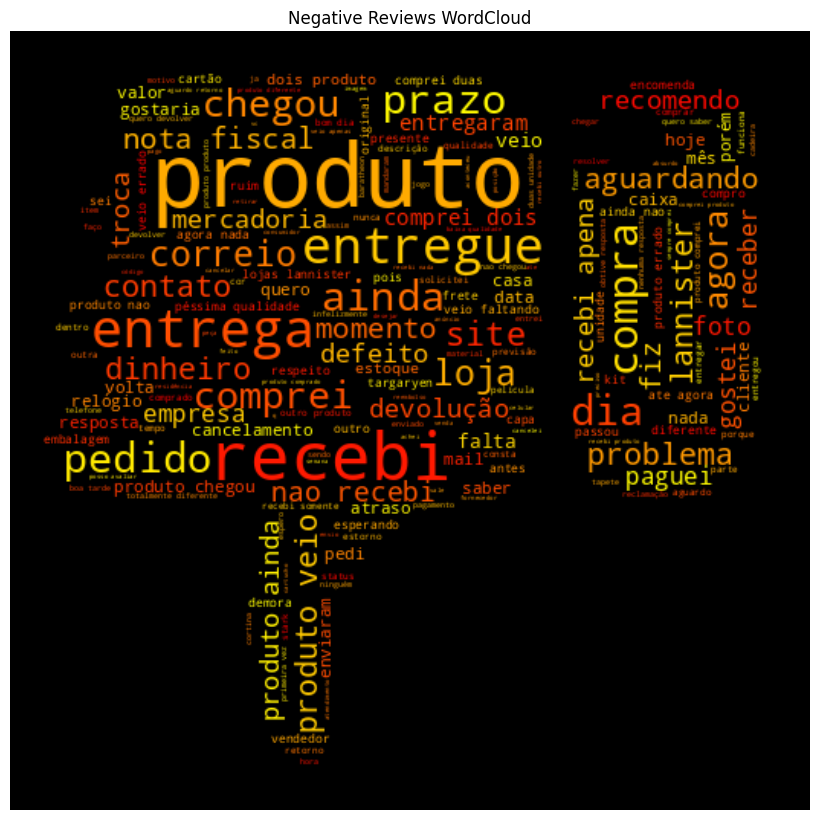

In [76]:
# Generate a word cloud image - Dislike
mask = np.array(Image.open("/content/drive/MyDrive/E-commerce Project/dislike3.jpg"))
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

wordcloud_dislike = WordCloud(height=2000, width=2000,
                              background_color="black", mode="RGBA",
                              stopwords=stopwords, mask=mask, colormap='autumn',
                              collocation_threshold = 3).generate(all_words)


plt.figure(figsize=[8, 8])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_dislike, interpolation="bilinear")
plt.title("Negative Reviews WordCloud")
# Store visualization to file
plt.savefig("dislike_wc.png", format="png")

plt.show()

In [77]:
like_clean_msg = clean_msg[clean_msg['review_score']>3]
all_words_like = ' '.join([word for word in like_clean_msg['processed_review_message']])

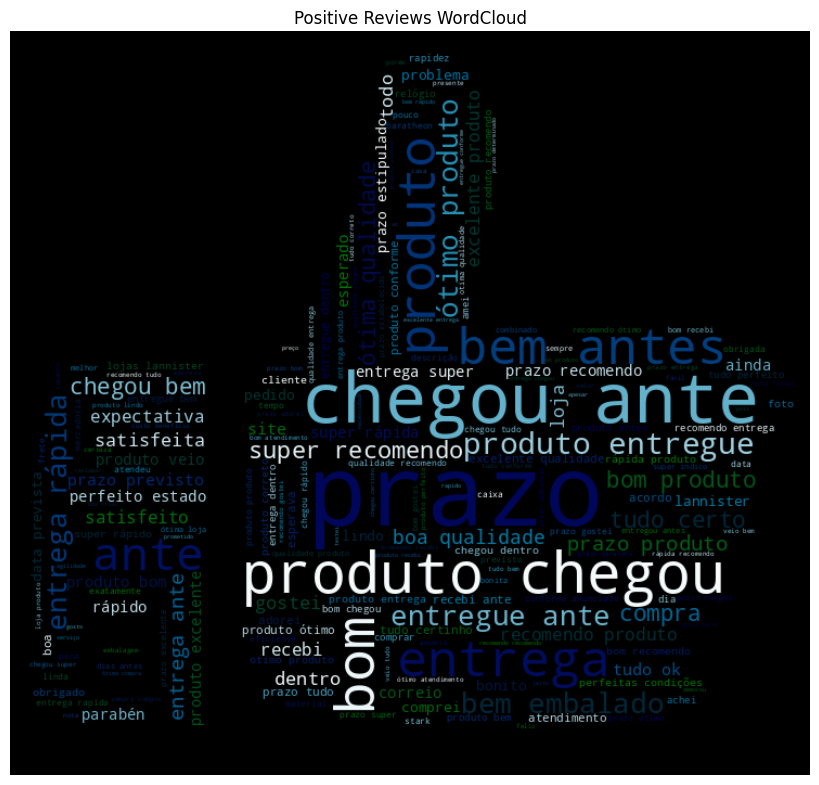

In [78]:
mask = np.array(Image.open("/content/drive/MyDrive/E-commerce Project/like.jpg"))
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

wordcloud_like = WordCloud(height=2000, width=2000,
                              background_color="black", mode="RGBA",
                              stopwords=stopwords, mask=mask, colormap='ocean',collocation_threshold = 3).generate(all_words_like)


plt.figure(figsize=[8, 8])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_like, interpolation="bilinear")
plt.title("Positive Reviews WordCloud")
# Store visualization to file
plt.savefig("like_wc.png", format="png")

plt.show()

Looking at both wordclouds, we can see that the dislike one shows words related to delay in the delivery date. While the positive rewiews are related with product and service quality.

## 3.2 Top Bigram and Trigrams - Negative and Positive Reviews

For the negative reviews:

In [79]:
stopwords = list(nltk.corpus.stopwords.words('portuguese'))

def get_top_n_ngrams(text, n=None, ngram=2):
    # Convert a collection of text documents to a matrix of token counts.  
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(text)
    # Transform documents to document-term matrix - term count array 
    bag_of_words = vec.transform(text)
    # Get the sum of a term - frequency count of each word in the entire corpus
    sum_words = bag_of_words.sum(axis=0)
    
    # vec.vocabulary_.items()-Returns a dictionary containing all the words in the corpus as keys and their corresponding index positions as values. 
    # iterates through the dictionary and creates a list of tuples
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    

    #  sorts the list of tuples in descending order based on the frequency count of each word in the corpus.
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


# # Get top 20 bigrams
# common_bigrams = get_top_n_ngrams(dislike_clean_msg['processed_review_message'], 20, ngram=2)
# print(common_bigrams)

# Get top 20 trigrams
trigrams = get_top_n_ngrams(dislike_clean_msg['processed_review_message'], 20, ngram=3)
print(trigrams)
df_trigrams = pd.DataFrame(trigrams, columns=['TrigramText', 'count'])

[('não recebi produto', 650), ('não foi entregue', 415), ('ainda não recebi', 375), ('até agora não', 199), ('produto não foi', 199), ('recebi meu produto', 192), ('prazo de entrega', 191), ('não recebi meu', 182), ('dinheiro de volta', 152), ('produto não chegou', 132), ('meu dinheiro de', 130), ('até momento não', 125), ('produto ainda não', 123), ('gostaria de saber', 121), ('veio com defeito', 117), ('ainda não chegou', 114), ('produto veio com', 103), ('nao recebi produto', 101), ('momento não recebi', 96), ('em contato com', 96)]


In [96]:
fig_trigrams = px.bar(df_trigrams, x='TrigramText', y='count', title='Trigram Counts', color = 'count',width=1000, height=800, color_continuous_scale='Jet')
fig_trigrams.update_xaxes(tickangle = 45)

fig_trigrams.show()

For the good reviews:


In [81]:
trigrams_positive = get_top_n_ngrams(like_clean_msg['processed_review_message'], 20, ngram=3)
print(trigrams_positive)
df_trigrams_positive = pd.DataFrame(trigrams_positive, columns=['TrigramText', 'count'])



[('antes do prazo', 3982), ('chegou antes do', 1181), ('dentro do prazo', 909), ('bem antes do', 824), ('entregue antes do', 598), ('entrega antes do', 419), ('chegou bem antes', 403), ('produto chegou antes', 393), ('produto muito bom', 390), ('de ótima qualidade', 380), ('entregue no prazo', 375), ('chegou no prazo', 346), ('antes da data', 339), ('antes do previsto', 328), ('prazo de entrega', 316), ('de boa qualidade', 314), ('do prazo previsto', 307), ('produto de qualidade', 304), ('muito antes do', 294), ('em perfeito estado', 289)]


In [95]:
fig_trigrams = px.bar(df_trigrams_positive, x='TrigramText', y='count', title='Trigram Counts', color = 'count',width=1000, height=800, color_continuous_scale='deep')
fig_trigrams.update_xaxes(tickangle = 45)
fig_trigrams.show()

 It is very clear how important the delivery time is for receiving both positive and negative reviews. Comments about the product quality are the second most commom in both extremes too.

## 3.4 Influence of Delivery Date

We can see by the WordClouds that the delivery date influence largely in the content of the reviews. Lets take a look ate the review score in relation with commitment with delivery date.  One can use the relationship the tables df_reviews and df_orders through order_id to retreive a score to a delayed delivery.


In [83]:
df_order_status.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [84]:
df_order_status[['order_delivered_customer_date', 'order_estimated_delivery_date']] = pd.to_datetime(df_order_status[['order_delivered_customer_date', 'order_estimated_delivery_date']].stack()).unstack()

In [85]:
df_order_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  object        
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(6)
memory usage: 6.1+ MB


In [86]:
df = pd.merge(df_order_status, df_reviews, on="order_id", how='inner')
df_delivery_date = df[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_score']]
df_delivery_date.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,4
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,4
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,5
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,5
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,5


In [87]:
deli_list=[]
for delivery, estimate in zip(df_delivery_date.order_delivered_customer_date, df_delivery_date.order_estimated_delivery_date):
  if delivery <= estimate:
    deli_list.append("On Time")
  else:
    deli_list.append("Delayed")
  
df_delivery_date["status"] = deli_list



<ipython-input-87-764e68c63089>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
df_delivery_date.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,review_score,status
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,4,On Time
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,4,On Time
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,5,On Time
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,5,On Time
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,5,On Time


<Figure size 1000x1200 with 0 Axes>

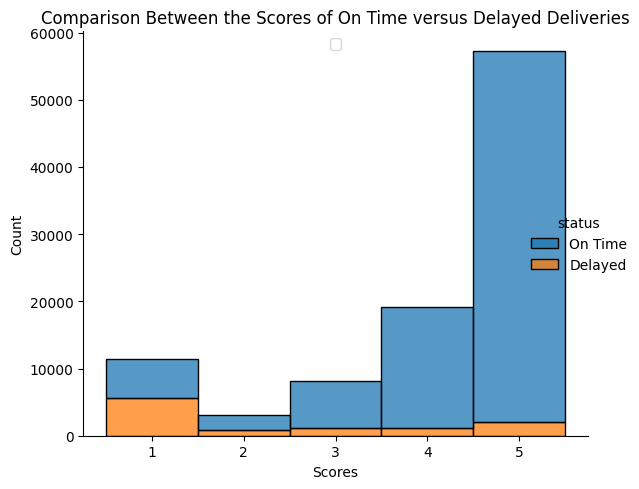

In [89]:
plt.figure(figsize=(10,12))
sns.displot(data=df_delivery_date, x='review_score', hue="status", multiple='stack', discrete=True)
plt.legend(loc='upper center')
plt.title("Comparison Between the Scores of On Time versus Delayed Deliveries")
plt.tight_layout()
plt.xlabel('Scores')

plt.show()

In [90]:
delayed = df_delivery_date[df_delivery_date.order_delivered_customer_date > df_delivery_date.order_estimated_delivery_date]
on_time = df_delivery_date[df_delivery_date.order_delivered_customer_date <= df_delivery_date.order_estimated_delivery_date]

In [91]:
print(f'The average score from delayed delivery is:{delayed.review_score.mean()}')
print(f'The average score from on time delivery is:{on_time.review_score.mean()}')


The average score from delayed delivery is:2.566549798727438
The average score from on time delivery is:4.293577567732184
